In [2]:
from src.sec_8k_preprocess import load_8k_filings, parse_8k_filing
from src.CRSP_ITI_FNSPID_merge import process_crsp_iti_fnspid_dataset
import polars as pl
import hvplot.polars
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_8k = load_8k_filings()
df_8k.head()

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...


cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950131-95-002984""",1995-10-27,1995-10-18,null,"""""","""001-06244""","""95584984""","""5,7""",8451,0,0,"""""","""FORM 8-K""",null,"""000095013195002984""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950109-95-002831""",1995-07-28,1995-06-30,null,"""""","""001-06244""","""95557157""","""5""",116160,0,0,"""""","""FORM 8-K""",null,"""000095010995002831""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000890613-95-000092""",1995-07-11,1995-07-07,null,"""""","""001-06244""","""95553269""","""5,7""",27032,0,0,"""""","""FORM 8-K""",null,"""000089061395000092""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001123""",1995-04-25,1995-04-10,null,"""""","""001-06244""","""95531061""","""5,7""",7025,0,0,"""""","""FORM 8-K CURRENT REPORT""",null,"""000095012395001123""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001008""",1995-04-13,1995-04-12,null,"""""","""001-06244""","""95528563""","""5,7""",6741,0,0,"""""","""FORM 8-K""",null,"""000095012395001008""","""https://www.sec.gov/Archives/e…"


In [4]:
df_8k = df_8k.with_columns((pl.col('filing_date') - pl.col('report_date')).alias('days_between_report_and_filing'))

In [5]:
# Filter to only include filings from 2004 onwards
df_8k = df_8k.filter(pl.col('report_date') >= pl.datetime(2004, 1, 1))

In [6]:
df_8k = df_8k.with_columns(pl.col("report_date").dt.year().alias("report_year"))
yearly_counts = df_8k.group_by('report_year').agg(pl.len().alias('count'))

In [7]:
yearly_counts.hvplot.bar(
    x="report_year",
    y="count",
    title="Yearly Counts",
    xlabel="Year",
    ylabel="Number of Reports",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [report_year]   (count)

In [8]:
# Filter to only include filings where the report date is within 30 days before the filing date
df_8k = df_8k.with_columns(
    (pl.col("days_between_report_and_filing").dt.total_seconds() / 86400)#Convert seconds to days
    .alias("days_between_report_and_filing_days")
).filter(
    pl.col("days_between_report_and_filing_days").is_between(0, 30)#Keep only filings where the report date is within 30 days before the filing date
)

In [9]:
df_8k.select(pl.col('days_between_report_and_filing')).describe()

statistic,days_between_report_and_filing
str,str
"""count""","""1474688"""
"""null_count""","""0"""
"""mean""","""2 days, 8:12:39.621560"""
"""std""",null
"""min""","""0:00:00"""
"""25%""","""0:00:00"""
"""50%""","""1 day, 0:00:00"""
"""75%""","""4 days, 0:00:00"""
"""max""","""30 days, 0:00:00"""


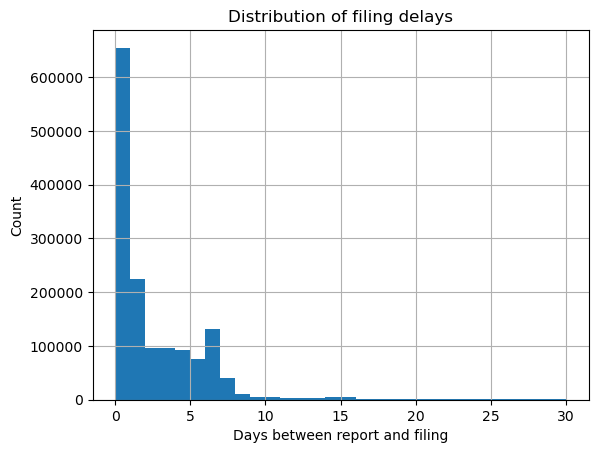

In [10]:
import matplotlib.pyplot as plt

df_8k.select(pl.col("days_between_report_and_filing_days")).to_pandas().hist(bins=30)
plt.xlabel("Days between report and filing")
plt.ylabel("Count")
plt.title("Distribution of filing delays")
plt.show()

In [11]:
# Keep only filings where the report date is at least 1 day before the filing date
df_8k = df_8k.filter(pl.col("days_between_report_and_filing_days") >= 1)